# 1) Factor Research & Signal Development — Earnings Quality

> Read me
- Run top-to-bottom. Uses simulated data only (numpy/pandas/matplotlib).
- Cells with **TODO** are what interviewers often expect you to implement.
- Keep runs fast. Vectorize when possible.
- Use clean functions with docstrings; add comments where you make assumptions.


## Setup & Data (simulated)

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

np.random.seed(42)

# --- Simulate panel ---
n_names = 800
n_sectors = 11
months = pd.period_range('2012-01','2020-12',freq='M')
dates = months.to_timestamp('M')
tickers = [f"U{i:04d}" for i in range(n_names)]
sectors = pd.Series(np.random.randint(0, n_sectors, size=n_names), index=tickers)

quality_level = pd.Series(np.random.normal(0, 1, n_names), index=tickers)

mi = pd.MultiIndex.from_product([dates, tickers], names=["date","ticker"])
df = pd.DataFrame(index=mi)

qtr_dates = pd.period_range('2011Q4','2020Q4',freq='Q')
qtr_ts = qtr_dates.to_timestamp('Q')
qtr_idx = pd.MultiIndex.from_product([qtr_ts, tickers], names=["date","ticker"])
fund = pd.DataFrame(index=qtr_idx)

sector_effect = pd.Series(np.random.normal(0,0.4,size=n_sectors), index=range(n_sectors))
fund["accruals"] = -0.7*quality_level.loc[fund.index.get_level_values("ticker")].values                    + sector_effect.loc[sectors.loc[fund.index.get_level_values("ticker")]].values                    + np.random.normal(0, 0.6, len(fund))

# bad code for ffill
# fund_m = (fund
#           .groupby(level="ticker")
#           .apply(lambda x: x.droplevel(0).reindex(dates, method="ffill"))
#           .swaplevel()
#           .sort_index())

fund_m = (fund['accruals']
          .unstack('ticker')             # columns = tickers
          .reindex(dates)                # index = monthly dates
          .ffill()                       # forward-fill across time per column
          .stack('ticker')               # back to MultiIndex (date, ticker)
          .to_frame('accruals')
          .sort_index())

df["accruals"] = fund_m["accruals"]
df["sector"] = sectors.loc[df.index.get_level_values("ticker")].values

market = pd.Series(np.random.normal(0.005, 0.04, len(dates)), index=dates, name="mkt")
beta = pd.Series(np.clip(np.random.normal(1.0, 0.3, n_names), 0.2, 2.0), index=tickers)
sector_shocks = pd.DataFrame(np.random.normal(0,0.02,(len(dates), n_sectors)),
                             index=dates, columns=[f"sec{i}" for i in range(n_sectors)])

# bad code to get sec_val for each stock row
# sec_cols = sector_shocks.columns
# sec_map = {i:sec_cols[i] for i in range(n_sectors)}
# sec_series = pd.Series(df["sector"].values, index=df.index)
# sec_shock_val = sector_shocks.stack()
# sec_lookup = sec_shock_val.copy()
# sec_lookup.index = pd.MultiIndex.from_tuples([(t, int(c.replace("sec",""))) for (t,c) in sec_shock_val.index])
# sec_val = sec_lookup.loc[(df.index.get_level_values("date"), sec_series.values)].values

# get sec_val for each stock row
date_idx = sector_shocks.index.get_indexer(df.index.get_level_values("date"))
sec_idx  = df["sector"].to_numpy()
# (len(df),) array of the right shape
sec_val = sector_shocks.to_numpy()[date_idx, sec_idx]

df["quality_score"] = -df["accruals"]
df["beta"] = beta.loc[df.index.get_level_values("ticker")].values

signal_strength = 0.006
idiosd = 0.06

df["ret"] = (market.loc[df.index.get_level_values("date")].values * df["beta"].values
             + 0.002*sec_val
             + signal_strength * df["quality_score"].values
             + np.random.normal(0, idiosd, len(df)))

panel = df.dropna().copy()


## TODO Checklist
1. **Winsorize** the raw factor cross-sectionally each month.
2. **Sector-standardize** (z-score within sector per month).
3. **Beta-neutralize** the factor via cross-sectional regression on beta each month.
4. Form **Q10–Q1 long–short** monthly returns; plot cumulative.
5. Compute **IC (Spearman)** and **IC decay** (1–6 months).
6. **Add turnover and a simple cost model**, and report net IR.
7. **Subperiod stability:** report metrics for 2012–2015, 2016–2020.


In [2]:
# === TODO 1–3: Build neutralized factor ===
def winsorize(s, p=0.01):
    lo, hi = s.quantile(p), s.quantile(1-p)
    return s.clip(lo, hi)

def zscore(s):
    return (s - s.mean())/s.std(ddof=0)

def neutralize_beta(df, factor: str, neutralizers: list):
    # TODO: implement via simple OLS residualization per month
    # add constant
    x = df[neutralizers].values
    y = df[factor].values
    X = np.c_[np.ones(len(x)), x]
    # X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X@beta
    return pd.Series(resid, index=df.index)

In [3]:
panel['fac_w'] = panel.groupby(['date', 'sector'])['quality_score'].transform(winsorize)
panel['fac_z'] = panel.groupby(['date', 'sector'])['fac_w'].transform(zscore)
panel['fac_n'] = panel.groupby(['date', 'sector']).apply(neutralize_beta, factor='fac_z', neutralizers=['beta']).values

/var/folders/kc/7dyzg2fs2zv9v849s3n6rd4w0000gn/T/ipykernel_30908/2355582593.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel['fac_n'] = panel.groupby(['date', 'sector']).apply(neutralize_beta, factor='fac_z', neutralizers=['beta']).values


In [4]:

# === TODO 4: Decile portfolio backtest ===
def decile_ls(panel, col, n_bins=10):
    tmp = panel.copy()
    tmp['tile'] = panel.groupby('date')[col].transform(lambda x : pd.qcut(x.rank(method='first'), n_bins, labels=False))
    long = tmp.loc[tmp.tile == n_bins-1].groupby('date')['ret'].mean()
    short = tmp.loc[tmp.tile == 0].groupby('date')['ret'].mean()
    ls = long - short
    return long, short, ls
long, short, ls = decile_ls(panel, col="fac_n")



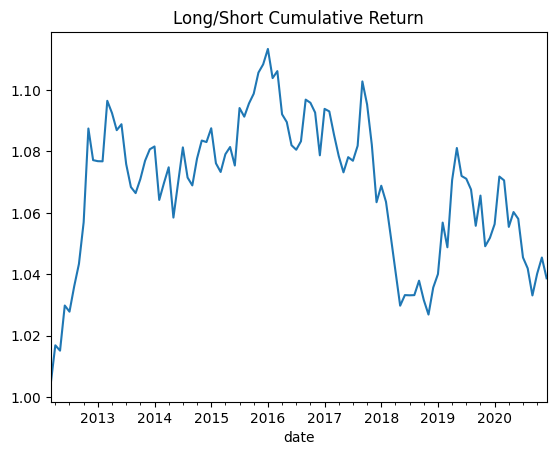

In [5]:
cum = (1+ls).cumprod()
plt.figure()
cum.plot(title='Long/Short Cumulative Return')
plt.show()

In [ ]:
# === TODO 5: IC and IC decay ===
# ic = ...

panel.groupby('date').apply(lambda x: spearmanr(x.fac_n, x.ret)[0]).dropna().plot(title='Monthly IC')

In [ ]:
# ic_decay = {k: ... for k in range(1,7)}
ic_decay = []
for k in range(1, 6+1):
    tmp = panel.copy()
    tmp['fwd_ret'] = tmp.groupby('ticker')['ret'].shift(-k)
    ic_decay_k = tmp.dropna(subset='fwd_ret').groupby('date').apply(lambda x : spearmanr(x.fwd_ret, x.fac_n)[0]).mean()
    ic_decay.append(ic_decay_k)
ic_decay = pd.DataFrame({'IC Lagged': ic_decay}, index=list(range(1, 7)))
ic_decay.plot(title='IC Decay')

In [ ]:
# === TODO 6: Turnover & cost ===
# Compute weights each month; turnover vs previous; subtract cost (e.g., 30bps per 100% turnover).
dates = panel.index.get_level_values(0).unique().sort_values()
tickers = panel.index.get_level_values(1).unique()

prev_w = pd.Series(0, index=tickers)

tc_per_turnover = 0.003

rets = []
for d in dates:
    snap = panel.loc[d]
    f = snap.fac_n
    w = f/f.abs().sum()
    w -= w.mean()
    to = (w - prev_w).abs().sum()
    r = (snap['ret'] * w).sum() - tc_per_turnover * to
    rets.append({'date': d, 'ret': r, 'turnover': to})
    prev_w = w

ret_to = pd.DataFrame(rets).set_index('date')

plt.figure()
(1 + ret_to.ret).cumprod().plot(title='Net of Costs Return')
plt.show()

In [ ]:

# === TODO 7: Subperiod stability ===
# Compute IR/IC for subperiods and print a small summary table